In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
DATA_PATH = "../data/processed/cicids2017_cleaned.csv"

def analyze_data():
    print("⏳ Loading dataset... (this might take a moment)")
    try:
        df = pd.read_csv(DATA_PATH)
    except FileNotFoundError:
        print(f"❌ File not found at {DATA_PATH}. Please check the path.")
        return

    print(f"✅ Data Loaded. Shape: {df.shape} (Rows, Columns)")

    # 1. Check Columns
    print("\n🔍 Column Names:")
    print(df.columns.tolist())

    # 2. Check Target Labels
    # Usually the column is named 'Label' or 'class'. Let's find it.
    target_col = None
    for col in df.columns:
        if 'label' in col.lower() or 'class' in col.lower():
            target_col = col
            break
    
    if target_col:
        print(f"\n🎯 Target Column Found: '{target_col}'")
        print("Distribution:")
        print(df[target_col].value_counts())
    else:
        print("\n⚠️ Could not automatically identify the Label column.")

    # 3. Check for Infinity/NaNs (Even 'cleaned' data can have these)
    print("\n🧹 Health Check:")
    missing = df.isnull().sum().sum()
    print(f" - Total Missing Values: {missing}")
    
    # Check for infinite values only if numeric columns exist
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        infinite = np.isinf(df[numeric_cols]).sum().sum()
        print(f" - Total Infinite Values: {infinite}")

    # 4. Correlation with Target (Optional - only if target is encoded)
    # This hints at which features are most important.
    
if __name__ == "__main__":
    analyze_data()

⏳ Loading dataset... (this might take a moment)
❌ File not found at ../data/processed/cicids2017_cleaned.csv. Please check the path.


⏳ Loading dataset...


✅ Using 252075 rows for feature selection.
🧠 Training Random Forest to rank features (this may take 1-2 mins)...

🏆 Top 20 Most Important Features:
                        Feature  Importance
11        Bwd Packet Length Std    0.094596
36       Packet Length Variance    0.084527
35            Packet Length Std    0.056975
3   Total Length of Fwd Packets    0.049915
40          Average Packet Size    0.047507
33            Max Packet Length    0.047252
10       Bwd Packet Length Mean    0.041658
34           Packet Length Mean    0.037370
41            Subflow Fwd Bytes    0.036348
4         Fwd Packet Length Max    0.027188
6        Fwd Packet Length Mean    0.024102
0              Destination Port    0.023598
20                  Fwd IAT Std    0.023580
16                 Flow IAT Max    0.023312
7         Fwd Packet Length Std    0.022301
2             Total Fwd Packets    0.022232
44             act_data_pkt_fwd    0.020471
43      Init_Win_bytes_backward    0.020272
8         Bwd Pa

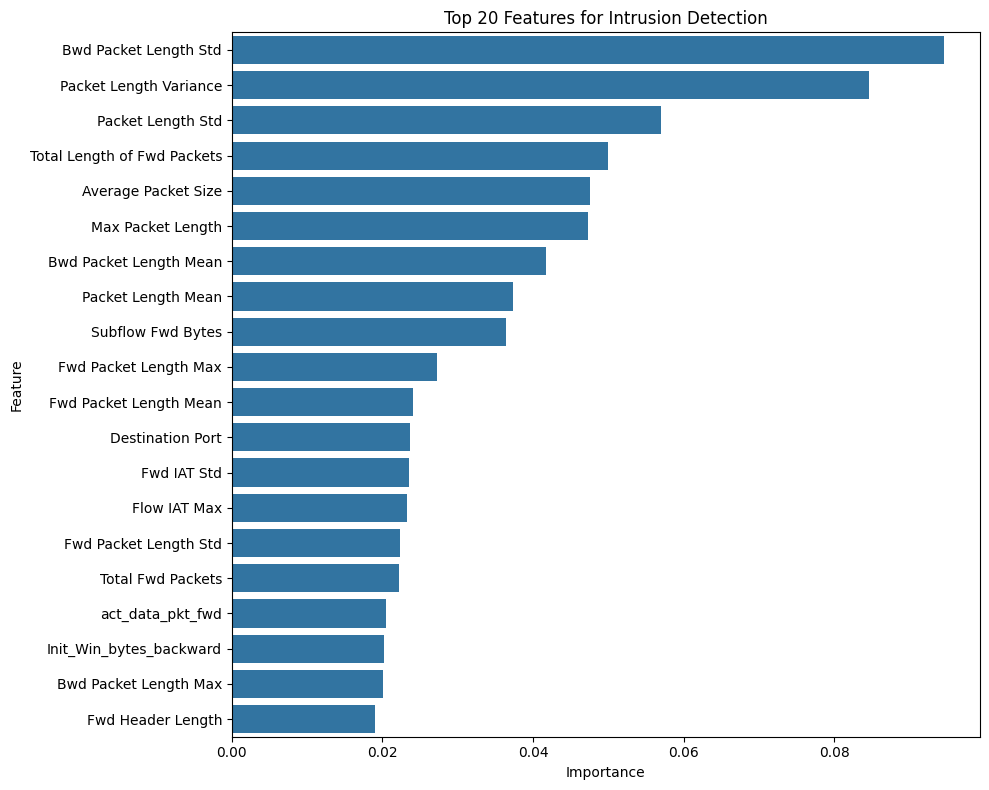

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Configuration
DATA_PATH = "../data/processed/cleaned_ids2017.csv"
TARGET_COL = "Attack Type"

def select_features():
    print("⏳ Loading dataset...")
    df = pd.read_csv(DATA_PATH)
    
    # 1. Sample the data
    # 2.5M rows is too much for a quick feature check. Let's use 10% (250k rows).
    df_sample = df.sample(frac=0.1, random_state=42)
    print(f"✅ Using {len(df_sample)} rows for feature selection.")

    # 2. Preprocessing
    # Separate Features (X) and Target (y)
    X = df_sample.drop(columns=[TARGET_COL])
    y = df_sample[TARGET_COL]

    # Encode the string labels (e.g., "DoS" -> 1, "Benign" -> 0)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # 3. Train Random Forest (The best model for feature importance)
    print("🧠 Training Random Forest to rank features (this may take 1-2 mins)...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y_encoded)

    # 4. Extract & Visualize Importance
    importances = rf.feature_importances_
    feature_names = X.columns
    
    # Create a DataFrame for nice printing
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

    # Print Top 20
    print("\n🏆 Top 20 Most Important Features:")
    print(feature_imp_df.head(20))
    
    # Save to CSV so we can reference it later when writing C++
    feature_imp_df.to_csv("feature_importance.csv", index=False)
    print("\n💾 Saved full list to 'feature_importance.csv'")

    # Optional: Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20))
    plt.title('Top 20 Features for Intrusion Detection')
    plt.tight_layout()
    # plt.savefig("feature_importance.png")
    # print("📊 Saved plot to 'feature_importance.png'")

if __name__ == "__main__":
    select_features()